In [ ]:
import pandas as pd
import os
import numpy as np
from scipy import signal
from mne.filter import resample

def filter_signal(dat:np.ndarray, 
                  band=[1,50], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

def preprocess_mist_data(path:str, fs:int=125):
    ROOT_PATH = path + '/Day 1/'
    subj_list = os.listdir(ROOT_PATH)
    print(subj_list)

    eeg_resting = []
    eeg = []
    label_rating = []
    label_target = []

    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(ROOT_PATH+subj)
        # print(subj, dat_list[0])
        if idx < 4:
            easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[2], delimiter='\t'), float).T
        else:
            easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[3], delimiter='\t'), float).T
        easy = easy_[:8,0::2]
        easy = resample(easy, down=500//fs)
        easy = filter_signal(easy, sampling_rate=125)

        event1 = np.where((0 < easy_[8]) & (easy_[8] < 10))[0] // 8
        event2 = np.where((10 <= easy_[8]) & (easy_[8] <= 20))[0] // 8
        if idx == 9:
            # savedata 없음         
            diff = np.diff(event2)
            i = np.where(diff > 15000)[0][0]
            easy[event1[0] : event2[i]] # train
            easy[event1[event1 < event2[i+1]][-1] : event2[-1]] # test
        else:
            t1 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_train.csv'), float).shape[0]+1
            t2 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_test.csv'), float).shape[0]+1

            easy[event2[t1-1] - event1[0]] # train
            easy[event2[-1] : event1[event2[t1-1] < event1][0]] # test
        
        event_r = np.where(easy_[8] == 90)[0] // 8
        easy[event_r[0]:event_r[0]+fs*210] # rs 1
        easy[event_r[1]:event_r[1]+fs*60] # rs 2
        easy[event_r[2]:event_r[2]+fs*60] # rs 3
        
        event_m = np.where(easy_[8]==120)[0][0] // 8
        easy[event_m - fs*330 : event_m] # meditation

    eeg = np.stack(eeg, 0)
    eeg_resting = np.stack(eeg_resting, 0)
    label_rating = np.stack(label_rating, 0)
    label_target = np.stack(label_target, 0)

    np.savez_compressed(f'{path}/emotion/emotion.npz', 
                        eeg=eeg, 
                        eeg_resting=eeg_resting, 
                        label_rating=label_rating, 
                        label_target=label_target)
    
# preprocess_mist_data('D:/One_한양대학교/private object minsu/coding/data/samsung_2024')

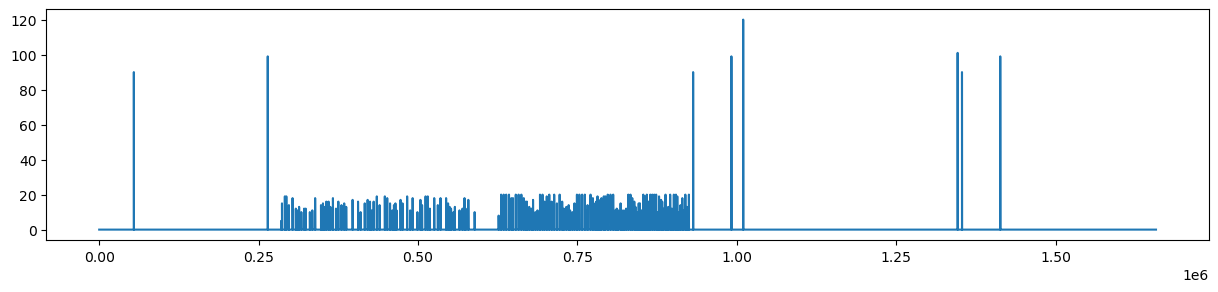

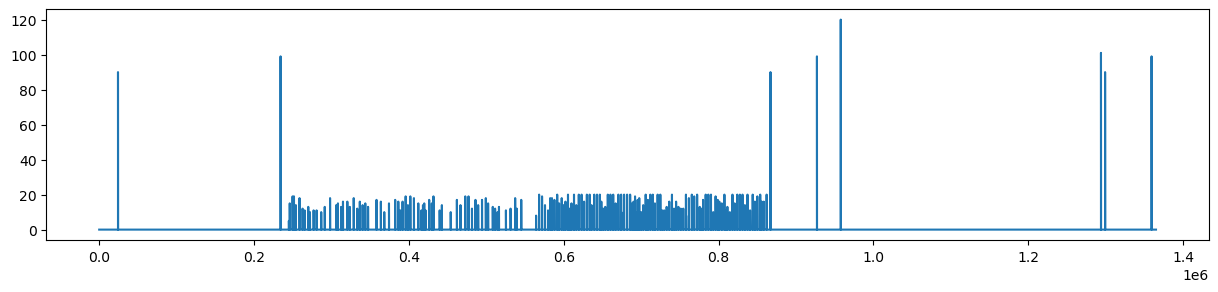

In [201]:
import matplotlib.pyplot as plt

path = 'D:/One_한양대학교/private object minsu/coding/data/samsung_2024'
ROOT_PATH = path + '/Day 1/'
subj_list = os.listdir(ROOT_PATH)

plt.figure(figsize=(15,3))
subj = subj_list[1]
dat_list = os.listdir(ROOT_PATH+subj)
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[2], delimiter='\t'), float).T
plt.plot(easy_[8])

plt.figure(figsize=(15,3))
subj = subj_list[9]
dat_list = os.listdir(ROOT_PATH+subj)
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[3], delimiter='\t'), float).T
plt.plot(easy_[8])

In [220]:
event1 = np.where((0 < easy_[8]) & (easy_[8] < 10))[0]
event2 = np.where((10 <= easy_[8]) & (easy_[8] <= 20))[0]

diff = np.diff(event2)
i = np.where(diff > 15000)[0][0]
len(event1), len(event2), event2[i], (event2[-1] - event1[event1 < event2[i+1]][-1])/60000, (event2[i] - event1[0])/60000, event2[i-1], event2[i], event2[i+1], 

(159, 173, 545165, 4.963, 5.0027333333333335, 539381, 545165, 568249)

In [223]:
event1[event1 < event2[i+1]][-1], event2[i+1]

(564349, 568249)

In [199]:
# for i in range(13,32):
plt.figure(figsize=(15,3))
subj = subj_list[10]
dat_list = os.listdir(ROOT_PATH+subj)
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[3], delimiter='\t'), float).T
t1 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_train.csv'), float).shape[0]+1
t2 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_test.csv'), float).shape[0]+1

event1 = np.where((0 < easy_[8]) & (easy_[8] < 10))[0]
event2 = np.where((10 <= easy_[8]) & (easy_[8] <= 20))[0]

# print((event2[t1-1] - event1[0])/60000, (event2[-1] - event1[event2[t1-1] < event1][0])/60000)
plt.plot(easy_[8])

print(event2[t1-1], event1[0], event2[-1], event2[-t2])
len(event1), len(event2), t1+t2, event2, (event2[t1-1] - event1[0])/60000, (event2[-1] - event1[event2[t1-1] < event1][0])/60000

FileNotFoundError: [Errno 2] No such file or directory: 'D:/One_한양대학교/private object minsu/coding/data/samsung_2024/Day 1/12.KJG(W)/savedata_train.csv'

<Figure size 1500x300 with 0 Axes>